1. Genere datos para el análisis

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 60  # estudiantes por materia

# Materia A: dispersión baja (notas más agrupadas)
a = rng.normal(loc=5.8, scale=0.6, size=n)

# Materia B: dispersión media
b = rng.normal(loc=5.6, scale=1.0, size=n)

# Materia C: dispersión alta + algunos atípicos
c = rng.normal(loc=5.7, scale=1.2, size=n)

# Recorte a rango típico de notas (1.0 a 7.0) para que tenga sentido en Chile
def clip_notas(x):
    return np.clip(x, 1.0, 7.0)

a = clip_notas(a)
b = clip_notas(b)
c = clip_notas(c)

# Elegimos índices y los reemplazamos por outliers
idx_out = rng.choice(len(c), size=4, replace=False)
c[idx_out] = [1.0, 1.1, 1.2, 7.0]   # outliers bajos/altos

df = pd.DataFrame({
    "Materia A": a,
    "Materia B": b,
    "Materia C": c
})

df.head()

,Materia A,Materia B,Materia C
0,5.982830,3.917130,4.471803
1,5.176010,5.265115,1.000000
2,6.250271,5.762753,5.963996
3,6.364339,6.186222,7.000000
4,4.629379,6.311227,6.702133


2. Calcule el rango intercuartílico (IQR) de cada materia.
3. Identifique valores atípicos utilizando el método de Q1 - 1.5×IQR y Q3 + 1.5×IQR

In [22]:
# 2) Función: IQR + límites + outliers
def iqr_outliers(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    out = s[(s < lim_inf) | (s > lim_sup)]
    return q1, q3, iqr, lim_inf, lim_sup, out

resumen = []
outliers_dict = {}

for col in df.columns:
    s = df[col].dropna()
    q1, q3, iqr, lim_inf, lim_sup, out = iqr_outliers(s)
    outliers_dict[col] = out

    resumen.append({
        "materia": col,
        "n": len(s),
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lim_inf": lim_inf,
        "lim_sup": lim_sup,
        "n_outliers": len(out),
        "media": s.mean(),
        "mediana": s.median(),
        "desv_std": s.std(ddof=1)
    })

tabla_resumen = pd.DataFrame(resumen).sort_values("IQR", ascending=False)

print("Resumen por materia (ordenado por IQR desc):")
print(tabla_resumen.round(3).to_string(index=False))

print("\nOutliers detectados por materia:")
for col, out in outliers_dict.items():
    if out.empty:
        print(f"- {col}: no hay outliers")
    else:
        print(f"- {col}: {sorted(out.round(2).tolist())}")



Resumen por materia (ordenado por IQR desc):
  materia  n    Q1    Q3   IQR  lim_inf  lim_sup  n_outliers  media  mediana  desv_std
Materia C 60 4.535 6.171 1.636    2.080    8.625           3  5.288    5.511     1.387
Materia B 60 4.989 6.049 1.060    3.399    7.639           0  5.411    5.378     0.763
Materia A 60 5.511 6.182 0.670    4.506    7.187           0  5.838    5.873     0.468

Outliers detectados por materia:
- Materia A: no hay outliers
- Materia B: no hay outliers
- Materia C: [1.0, 1.1, 1.2]


4. Construye un boxplot comparativo entre materias.

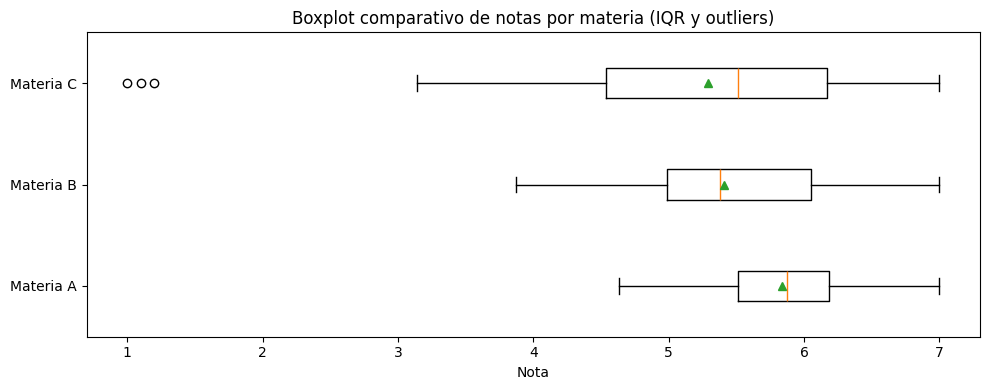

In [24]:
# 3) Boxplot comparativo
plt.figure(figsize=(10, 4))
plt.boxplot(
    [df["Materia A"].dropna(), df["Materia B"].dropna(), df["Materia C"].dropna()],
    vert=False,
    tick_labels=["Materia A", "Materia B", "Materia C"],
    showmeans=True, showfliers=True
)
plt.title("Boxplot comparativo de notas por materia (IQR y outliers)")
plt.xlabel("Nota")
plt.tight_layout()
plt.show()

5. Analice e interprete:

- ¿Que materia tiene mayor dispersión?
- ¿Cual presenta más valores extremos?
- ¿Que medida de tendencia central representa mejor cada conjunto?


In [19]:
# 4) Preguntas
materia_mayor_disp = tabla_resumen.iloc[0]["materia"]  # mayor IQR
materia_mas_out = tabla_resumen.sort_values("n_outliers", ascending=False).iloc[0]["materia"]

print("\nInterpretación rápida")
print(f"- Mayor dispersión (según IQR): {materia_mayor_disp}")
print(f"- Más valores extremos (según conteo de outliers): {materia_mas_out}")

print("\n¿Media o mediana?")
for _, row in tabla_resumen.iterrows():
    m = row["materia"]
    n_out = int(row["n_outliers"])
    if n_out > 0:
        recomendacion = "Mediana (más robusta por outliers)"
    else:
        recomendacion = "Media (si la distribución es más 'limpia')"
    print(f"- {m}: {recomendacion}")


Interpretación rápida
- Mayor dispersión (según IQR): Materia C
- Más valores extremos (según conteo de outliers): Materia C

¿Media o mediana?
- Materia C: Mediana (más robusta por outliers)
- Materia B: Media (si la distribución es más 'limpia')
- Materia A: Media (si la distribución es más 'limpia')
